# Unmixing coercivity spectra from backfield curves

## Background on coercivity spectra

Natural samples contain ferromagnetic materials dispersed in paramagnetic and/or diamagnetic matrix material. Ferromagnetic mineral assemblages can be composed of minerals with different compositions, shapes, and sizes, such that they have different coercivities. Coercivity refers to the resistance of a ferromagnetic material to becoming demagnetized in the presence of an applied field. It is common in the fields of rock and environmental magnetism to use backfield magnetic remanence curves to gain insight into coercivity and thereby the ferromagnetic mineral assemblage within samples. Alternatively, a similar analysis can be conducted on isothermal remanent magnetization (IRM) acquisition or alternating field (AF) demagnetization data.

A backfield experiment is typically conducted on a vibrating sample magnetometer (VSM). In such an experiment, a strong external field is applied to the sample in one direction to induce a saturation isothermal remanent magnetization (sIRM), followed by the application of a field in the opposite direction. The process is repeated with the sIRM being applied, followed by reverse fields that are progressively larger in each step of the experiment. The derivative of the resultant backfield curve is referred to as the coercivity spectra. A common data analysis workflow is to fit components of this spectra to ‘unmix’ different populations of magnetic minerals.

Available programs for processing backfield coercivity curves include Max UnMix, IRM UnMix, GECA, IRM-CLG.

### Here is an example output of backfield unmixing results from Max UnMix (written in R):

This notebook largely follows the workflow of Max UnMix. We consider the total measured coercivity spectra as a sum of a number of skew-normal distributions. There is a difference between the method in this approach and that of Max UnMix in terms of uncertainty propagation. This programs utilizes the package `lmfit` which imbeds an uncertainty propagation procedure based on the covariance of the parameters of the fitted skew-normal distribution. Max UnMix program calculates uncertainty by bootstrapping the data.

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/MaxUnmix_example.png" alt="Description of the image" width="400">
</figure>

**MAX UnMix: A web application for unmixing magnetic coercivity distributions. DOI: http://dx.doi.org/10.1016/j.cageo.2016.07.009**

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [1]:
import pmagpy.rockmag as rmag

import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, VBox, HBox
import ipywidgets as widgets
from IPython.display import display

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

pd.set_option('display.max_columns', 500)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data


In [2]:
# define the path to the folder 
dir_path = '../example_data/SSRM2024C'
# download the data from the MagIC database using my private contribution key 
result, magic_file = ipmag.download_magic_from_id('20133', directory=dir_path, share_key='3b58527f-872b-4e64-a0f1-1e57120c9f15')
# unpack the MagIC file
ipmag.unpack_magic(magic_file, dir_path)
# get the contribution object
contribution = cb.Contribution(dir_path)
# get the measurements table
measurements = contribution.tables['measurements'].df
measurements.dropna(axis=1, how='all')

Download successful. File saved to: ../example_data/SSRM2024C/magic_contribution_20133.txt
working on:  'contribution'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/contribution.txt
contribution  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/contribution.txt
working on:  'locations'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/locations.txt
locations  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/locations.txt
working on:  'sites'
16  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/sites.txt
sites  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/sites.txt
working on:  'samples'
28  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/samples.txt
samples  data put in  /Users/yimingzhang/Github/Ro

,dir_dec,dir_inc,experiment,instrument_codes,magn_mass,magn_moment,magn_r2_det,magn_x,magn_y,magn_z,meas_field_ac,meas_field_dc,meas_freq,meas_pos_z,meas_temp,measurement,method_codes,quality,sequence,software_packages,specimen,standard,susc_chi_mass,susc_chi_qdr_mass,timestamp,treat_ac_field,treat_dc_field
measurement name,,,,,,,,,,,,,,,,,,,,,,,,,,,
IRM-Magnon-14466-0,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000377,NaN,31.0,NaN,293.0,IRM-Magnon-14466-0,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001594,0.000006,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-1,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000377,NaN,305.0,NaN,293.0,IRM-Magnon-14466-1,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001610,0.000006,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-2,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000377,NaN,1030.0,NaN,293.0,IRM-Magnon-14466-2,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001605,0.000014,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-3,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000151,NaN,1030.0,NaN,293.0,IRM-Magnon-14466-3,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001600,0.000012,2024:06:05:15:51:58.00,NaN,NaN
IRM-Magnon-14466-4,NaN,NaN,IRM-Magnon-LP-X:LP-X-F:LP-X-H-14466,IRM-Magnon,NaN,NaN,NaN,NaN,NaN,NaN,0.000050,NaN,1030.0,NaN,293.0,IRM-Magnon-14466-4,LP-X:LP-X-F:LP-X-H,g,NaN,IRMDB Version2,MA1-1b,u,0.001590,0.000010,2024:06:05:15:51:58.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nan,38.182488,23.926673,"SJ1-5b-NRM_demag(T,Hac)-LP-DIR-AF-0",IRM-SRM-U,NaN,5.942540e-08,NaN,4.269700e-08,3.357810e-08,2.410100e-08,NaN,NaN,NaN,0.45,NaN,None,LP-DIR-AF,None,NaN,None,SJ1-5b,None,NaN,NaN,2024:06:05:09:35:29.00,0.17,NaN
nan,-194.492598,-32.183836,"MA1-1b-NRM_demag(T,Hac)-LP-DIR-AF-0",IRM-SRM-U,NaN,2.107890e-06,NaN,-1.727230e-06,4.464540e-07,-1.122740e-06,NaN,NaN,NaN,0.65,NaN,None,LP-DIR-AF,None,NaN,None,MA1-1b,None,NaN,NaN,2024:06:05:09:35:51.00,0.17,NaN
nan,-215.249814,-18.923425,"MA1-2b-NRM_demag(T,Hac)-LP-DIR-AF-0",IRM-SRM-U,NaN,8.466490e-07,NaN,-6.540420e-07,4.622280e-07,-2.745720e-07,NaN,NaN,NaN,0.85,NaN,None,LP-DIR-AF,None,NaN,None,MA1-2b,None,NaN,NaN,2024:06:05:09:36:13.00,0.17,NaN


## now let's extract the backfield experiment data (LP-BCR-BF) from the measurements table

- let's filter for the experiment with a protocol of `LP-BCR-BF` which stands for lab protocol-backfield coercivity remanence-backfield
- columns `magn_mass` and `treat_dc_field` contain the magnetization (mass normalized) and the applied back field respectively.

In [3]:
# filter for backfield measurements
backfield_measurements = measurements[measurements.method_codes == 'LP-BCR-BF']
# let's drop the empty columns
backfield_measurements = backfield_measurements.dropna(axis=1, how='all')
# let's inspec the data table
backfield_measurements.head()

,experiment,instrument_codes,magn_mass,measurement,method_codes,quality,specimen,standard,timestamp,treat_dc_field
measurement name,,,,,,,,,,
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393701,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.002470,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393701,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.000070
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393702,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.001872,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393702,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.005054
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393703,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.001353,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393703,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.010090
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393704,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.000952,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393704,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.015070
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393705,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.000591,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393705,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.020050


### We need to do some preprocessing on the raw data in order to unmix the spectrum

pick your own `smooth_frac` value between 0 and 1 for smoothing the raw backfield data

## Example 1

In [4]:
specimne_1 = 'SJ1-4-r gelcap'
experiment_1 = 'IRM-VSM4-LP-BCR-BF-239364'
smooth_frac = 0.0

selected_experiment = backfield_measurements[(backfield_measurements['specimen']==specimne_1) & 
                                      (backfield_measurements['experiment']==experiment_1)].reset_index(drop=1)
selected_experiment = rmag.backfield_data_processing(selected_experiment, smooth_frac=smooth_frac)

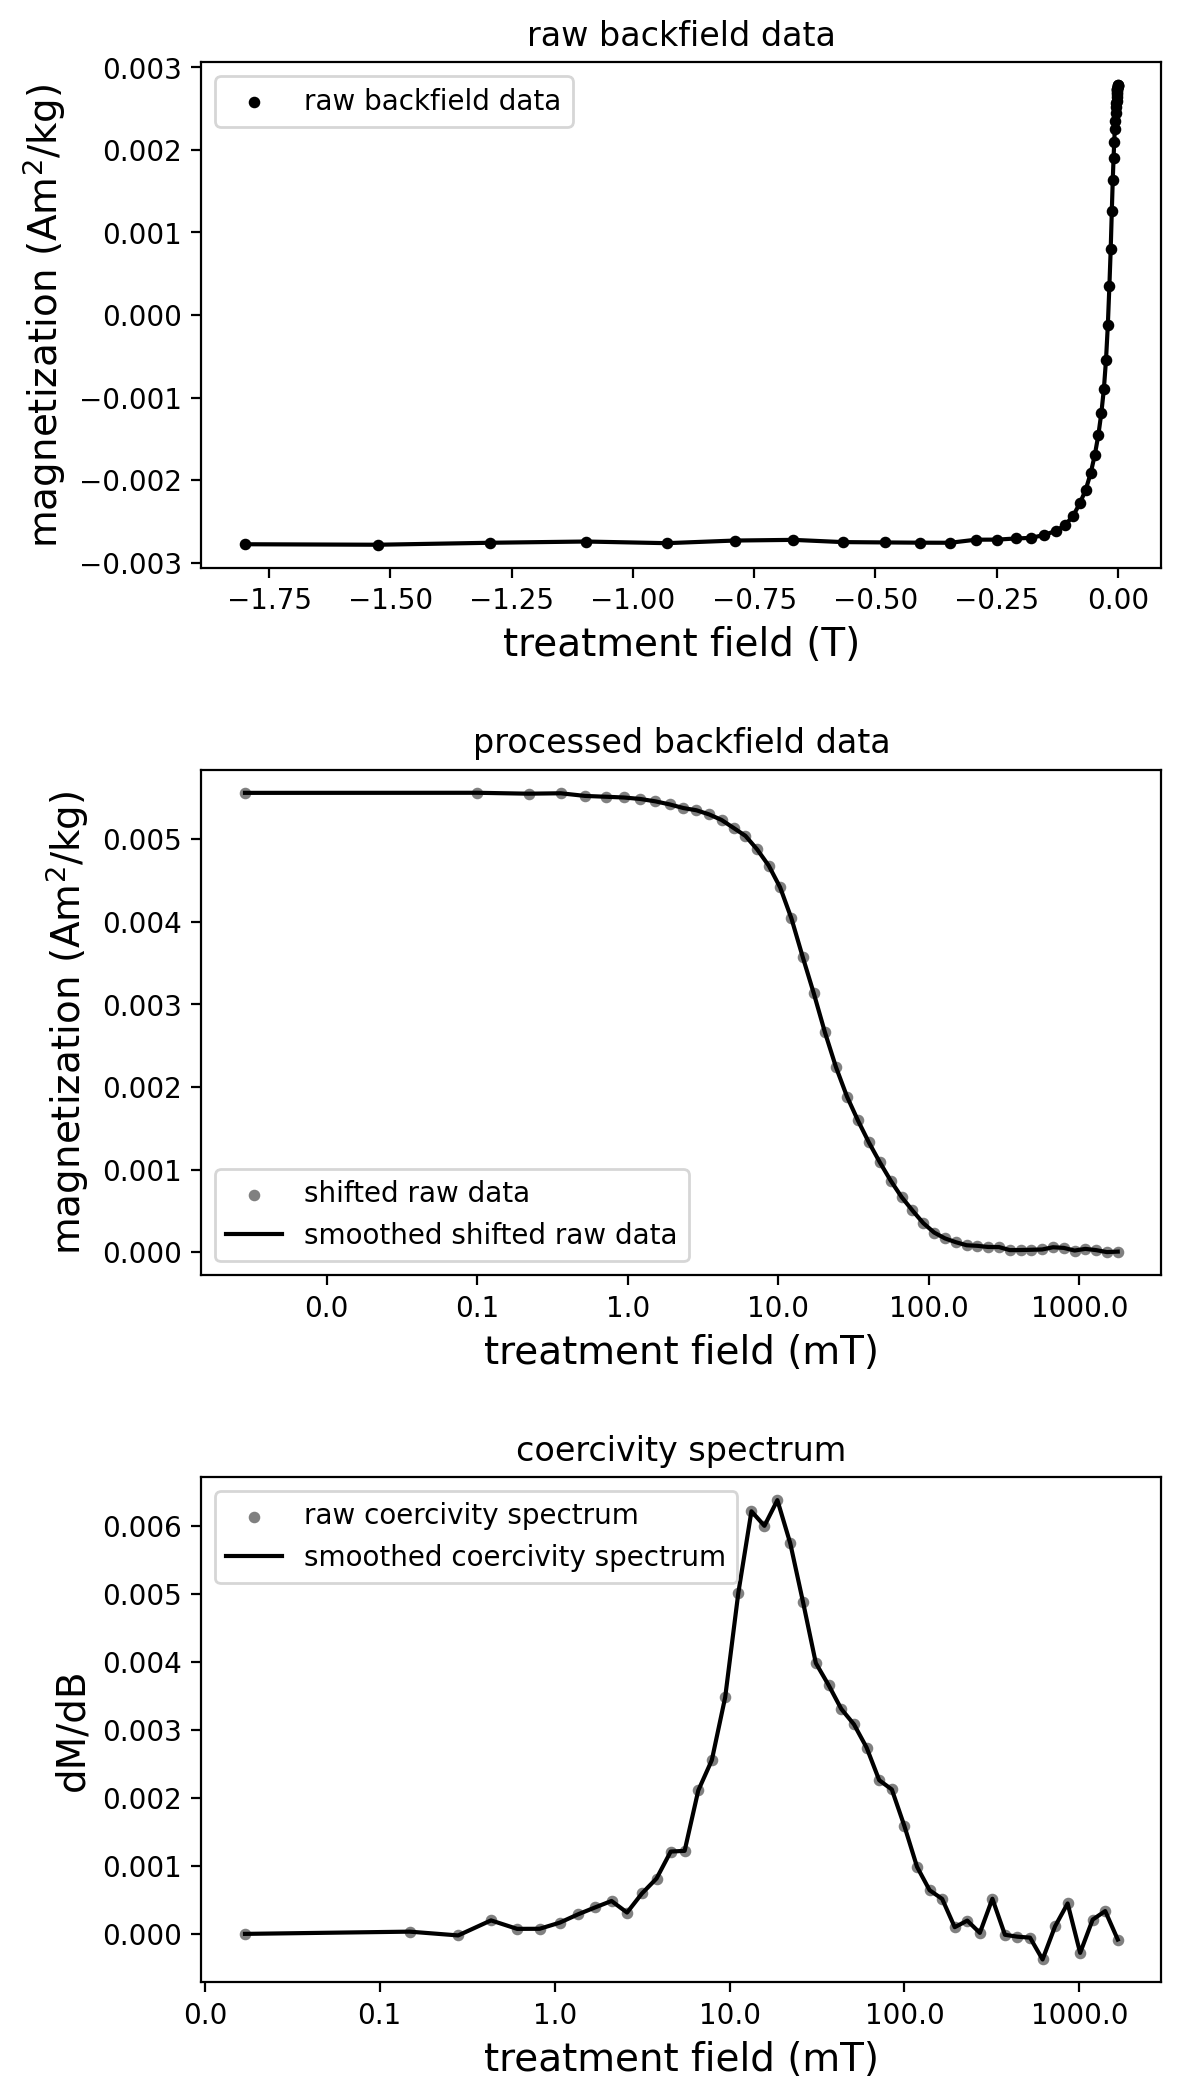

In [5]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(selected_experiment, figsize=(6, 12))

### set up initial guesses for skewnormal distribution parameters

- we need to set up a Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- `amplitude` represents the relative height of the peak, i.e. the maximum amplitutde should be 1. 
- `center` represents the x axis value of the peak in unit of mT
- `sigma` represents the width of the peak in unit of mT
- `gamma` represents the skewness of the peak, should be between -1 and 1

In [6]:
parameters = pd.DataFrame({'amplitude': [0.5], 'center': [10], 'sigma': [10.0], 'gamma': [0]})
parameters

,amplitude,center,sigma,gamma
0,0.5,10,10.0,0


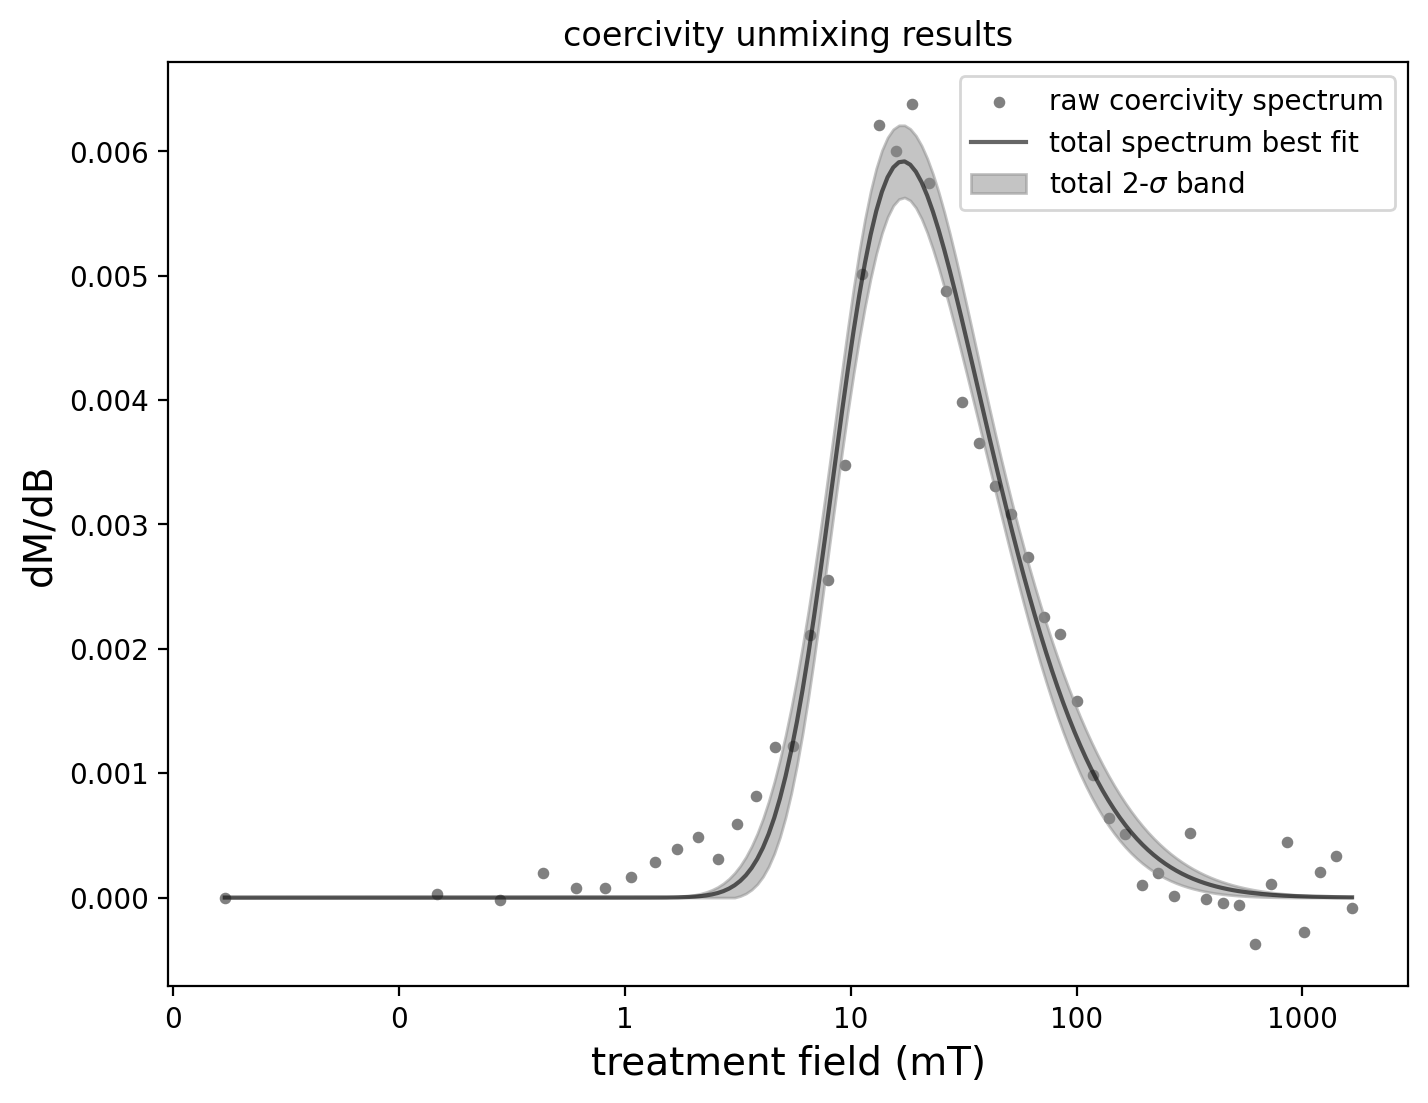

In [7]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment['smoothed_log_dc_field'], selected_experiment['smoothed_magn_mass_shift'], n_comps=1, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

## Example 2

- we can also try to fit this data with two components

### set up initial guesses for skewnormal distribution parameters

- you need to set up your own Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- the parameter table gets updated each time you run the unmixing algorithm

In [ ]:
parameters = pd.DataFrame({'amplitude': [0.1, 0.5], 'center': [9, 50], 'sigma': [10.0, 10], 'gamma': [0, 0]})
parameters

,amplitude,center,sigma,gamma
0,0.1,9,10.0,0
1,0.5,50,10.0,0


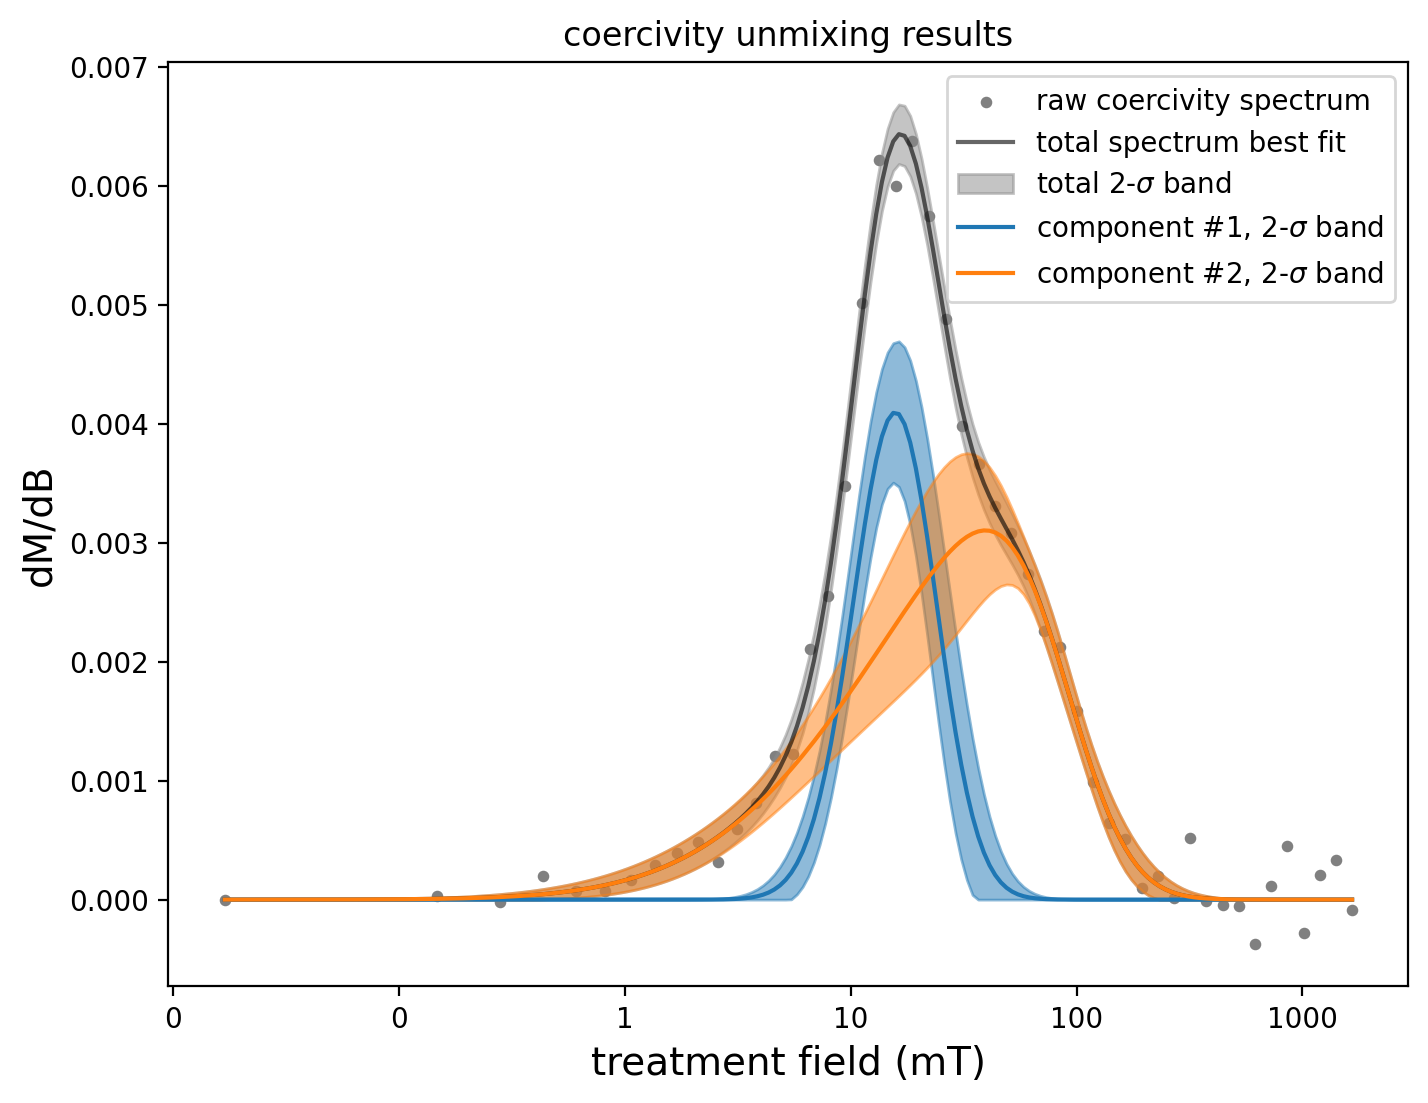

In [ ]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment['smoothed_log_dc_field'], selected_experiment['smoothed_magn_mass_shift'], n_comps=2, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

## Example 3

In [ ]:
specimne_2 = 'MA1-OX-r'
experiment_2 = 'IRM-VSM4-LP-BCR-BF-239379'
smooth_frac = 0.03

selected_experiment = backfield_measurements[(backfield_measurements['specimen']==specimne_2) & 
                                      (backfield_measurements['experiment']==experiment_2)].reset_index(drop=1)
selected_experiment = rmag.backfield_data_processing(selected_experiment, smooth_frac=smooth_frac)

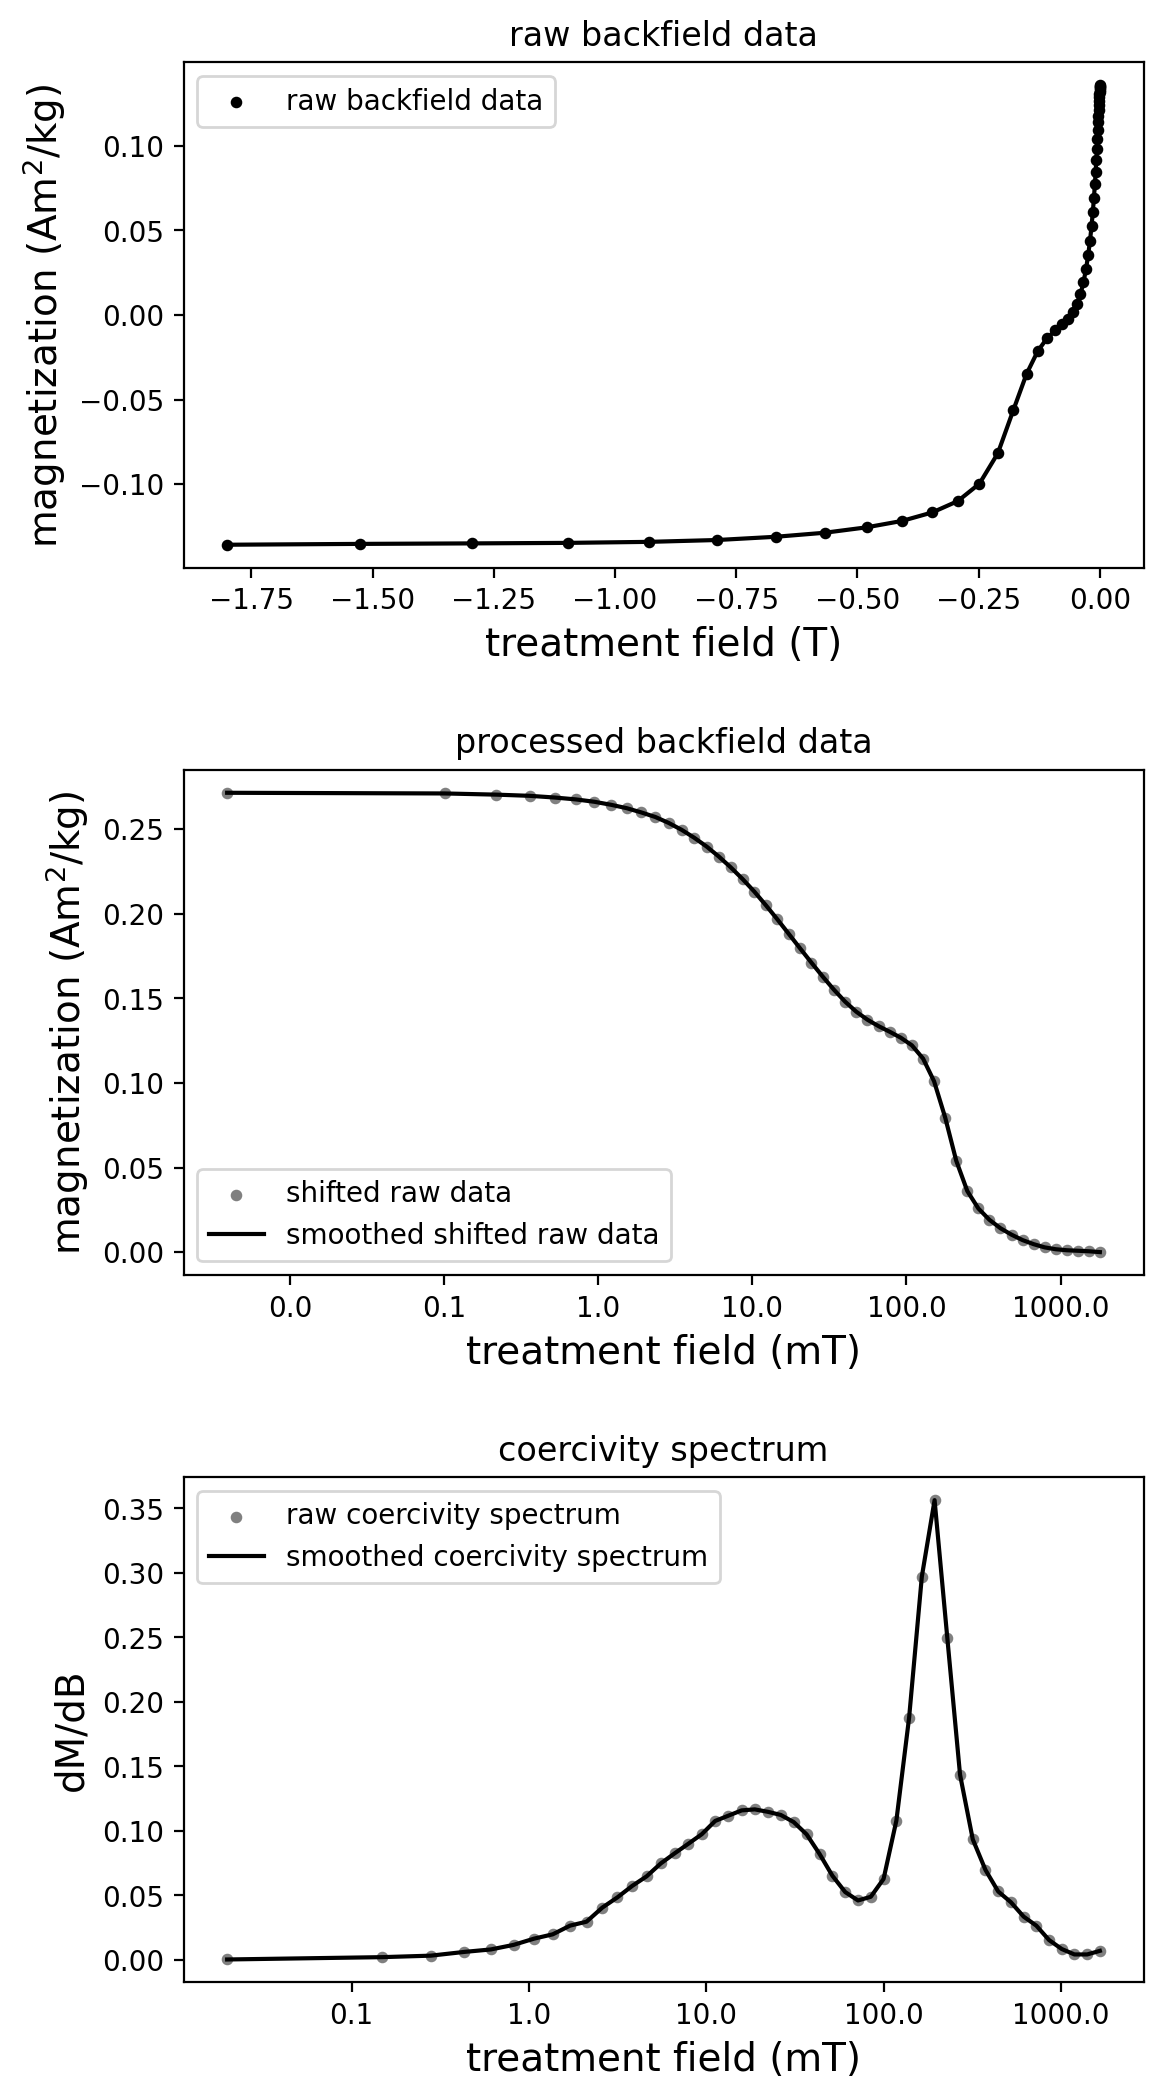

In [ ]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(selected_experiment, figsize=(6, 12))

### set up initial guesses for skewnormal distribution parameters

- you need to set up your own Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- the parameter table gets updated each time you run the unmixing algorithm

In [ ]:
parameters = pd.DataFrame({'amplitude': [0.1, 0.3, 0.1], 'center': [10, 100, 1000], 'sigma': [3, 10, 50], 'gamma': [0, 0, 0]})
parameters

,amplitude,center,sigma,gamma
0,0.1,10,3,0
1,0.3,100,10,0
2,0.1,1000,50,0


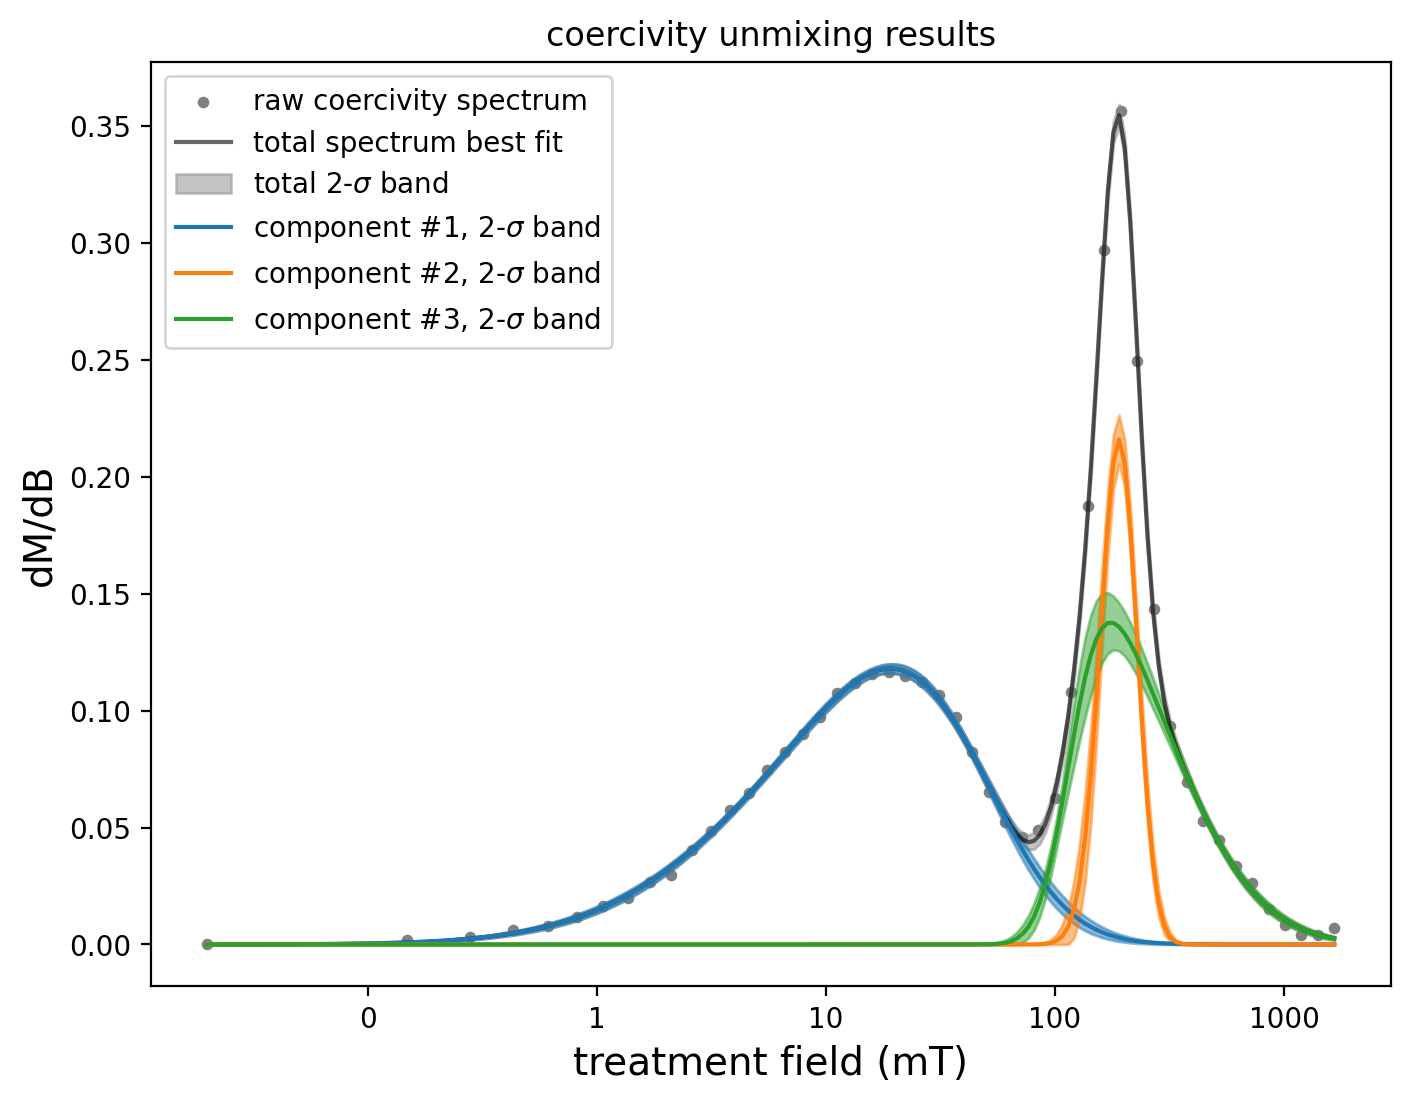

In [ ]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment['smoothed_log_dc_field'], selected_experiment['smoothed_magn_mass_shift'], n_comps=3, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

## Example 4
- MaxUnmix example data file

In [8]:
MaxUmnix_data = pd.read_csv('../example_data/backfield_unmixing/MaxUnmix_example.csv')
MaxUmnix_data['B'] = -MaxUmnix_data['B']/1000
MaxUmnix_data

,B,M
0,-0.00146,6.950000e-06
1,-0.00224,6.930000e-06
2,-0.00305,6.900000e-06
3,-0.00389,6.860000e-06
4,-0.00477,6.830000e-06
...,...,...
93,-0.84446,3.320000e-07
94,-0.88053,2.450000e-07
95,-0.91852,1.590000e-07
96,-0.95798,7.670000e-08


In [9]:
MaxUmnix_experiment = rmag.backfield_data_processing(MaxUmnix_data, field='B', magnetization='M', smooth_frac=smooth_frac)

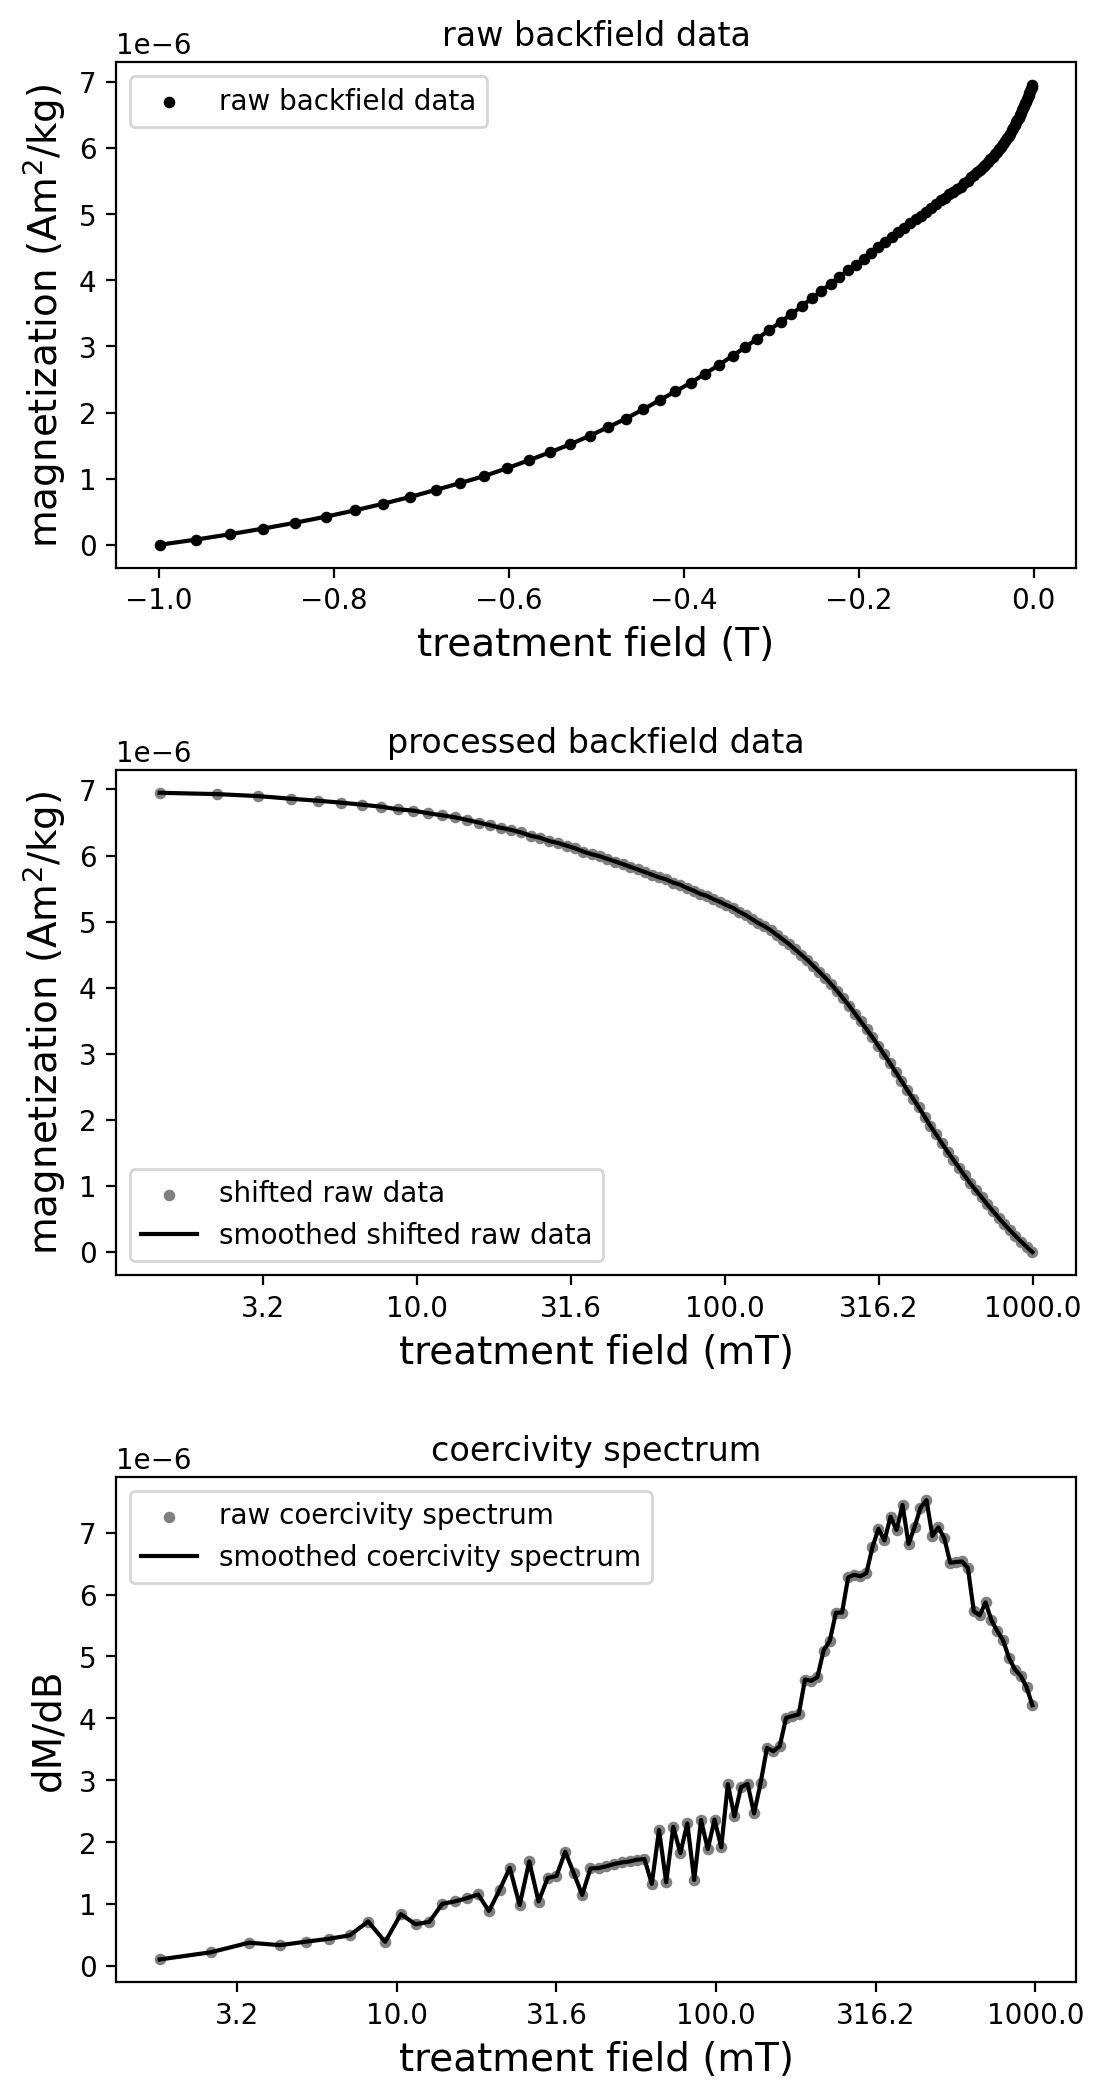

In [10]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(MaxUmnix_experiment, field='B', magnetization='M', figsize=(6, 12))

In [18]:
def interactive_backfield_fit(field, magnetization, n_components, figsize=(10, 6)):
    '''
    Function for interactive backfield unmixing using skew-normal distributions.
    '''

    # Calculate the smoothed derivative
    smoothed_derivatives_y = -np.diff(magnetization) / np.diff(field)
    smoothed_derivatives_x = pd.Series(field).rolling(window=2).mean().dropna()

    fig, ax = plt.subplots(figsize=figsize)
    fig.canvas.header_visible = False

    # Store all sliders and text
    sliders = []
    texts = []

    def create_slider_dict(name, min_val, max_val, step, description):
        return {
            f"{name}_{i}": FloatSlider(
                value=0.0,
                min=min_val,
                max=max_val,
                step=step,
                description=f'{description}_{i+1}',
                continuous_update=False
            )
            for i in range(n_components)
        }

    amp_slidebars = create_slider_dict('amplitude', 0.0, 1, 0.01, 'amplitude')
    center_slidebars = create_slider_dict('center', 0.0, 10**np.max(field), 10**np.max(field) / 100, 'center')
    sigma_slidebars = create_slider_dict('sigma', 0.0, 10**np.max(field), 10**np.max(field) / 100, 'sigma')
    gamma_slidebars = create_slider_dict('gamma', -1.0, 1.0, 0.01, 'gamma')

    # Collect all sliders by component for display and registration

    for i in range(n_components):
        # Create sliders for each component
        amp_slider = amp_slidebars[f'amplitude_{i}']
        center_slider = center_slidebars[f'center_{i}']
        sigma_slider = sigma_slidebars[f'sigma_{i}']
        gamma_slider = gamma_slidebars[f'gamma_{i}']
        # Create a dictionary for each component
        d = {
            'amplitude': amp_slider,
            'center': center_slider,
            'sigma': sigma_slider,
            'gamma': gamma_slider
        }
        # Add sliders to the list
        sliders.append(VBox([amp_slider, center_slider, sigma_slider, gamma_slider]))

    # now add the same amount of text boxes to update the best fit parameters on the fly
    for i in range(n_components):
        # make text boxes for each parameter
        amp_text = widgets.Text(value=str(amp_slidebars[f'amplitude_{i}'].value), description=f'amplitude_{i+1}')
        center_text = widgets.Text(value=str(center_slidebars[f'center_{i}'].value), description=f'center_{i+1}')
        sigma_text = widgets.Text(value=str(sigma_slidebars[f'sigma_{i}'].value), description=f'sigma_{i+1}')
        gamma_text = widgets.Text(value=str(gamma_slidebars[f'gamma_{i}'].value), description=f'gamma_{i+1}')
        # add the text boxes to the texts list
        texts.append(VBox([amp_text, center_text, sigma_text, gamma_text]))

    # Display sliders
    display(HBox(sliders))
    display(HBox(texts))

    def update_plot(*args):
        ax.clear()
        ax.scatter(smoothed_derivatives_x, smoothed_derivatives_y, marker='o', color='grey', label='original data')
        ax.set_xlabel('Field', fontsize=12)
        ax.set_ylabel('dM/dB', fontsize=12)

        # Get values from sliders
        amp = [amp_slidebars[f'amplitude_{i}'].value  for i in range(n_components)]
        center = [center_slidebars[f'center_{i}'].value for i in range(n_components)]
        sigma = [sigma_slidebars[f'sigma_{i}'].value for i in range(n_components)]
        gamma = [gamma_slidebars[f'gamma_{i}'].value for i in range(n_components)]
        
        # Create a DataFrame for the parameters
        parameters = pd.DataFrame({
            'amplitude': amp,
            'center': center,
            'sigma': sigma,
            'gamma': gamma
        })

        result, updated_parameters = rmag.backfield_unmixing(field, magnetization, n_comps=n_components, parameters=parameters)
        # update the text boxes with the updated parameters
        for i in range(n_components):
            amp_text = texts[i].children[0]
            center_text = texts[i].children[1]
            sigma_text = texts[i].children[2]
            gamma_text = texts[i].children[3]
            amp_text.value = str(updated_parameters['amplitude'][i].round(4))
            center_text.value = str(updated_parameters['center'][i].round(4))
            sigma_text.value = str(updated_parameters['sigma'][i].round(4))
            gamma_text.value = str(updated_parameters['gamma'][i].round(4))

        ax.plot(field, result.eval(x=field), '-', color='k', alpha=0.6, label='total spectrum best fit')
        if len(result.components) > 1:
            for i in range(len(result.components)):
                this_comp = result.eval_components(x=field)[f'g{i+1}_']
                ax.plot(field, this_comp, c=f'C{i}', label=f'component #{i+1}, {sigma[i]:.2f}-$\sigma$')

        ax.set_xticklabels([f'{int(10**i)}' for i in ax.get_xticks()])
        ax.legend()

        fig.canvas.draw()

    # Attach observers
    for box in sliders:
        for slider in box.children:
            if isinstance(slider, FloatSlider):
                slider.observe(update_plot, names='value')

    update_plot()


   amplitude  center  sigma  gamma
0        0.0    1.46    1.0    0.0


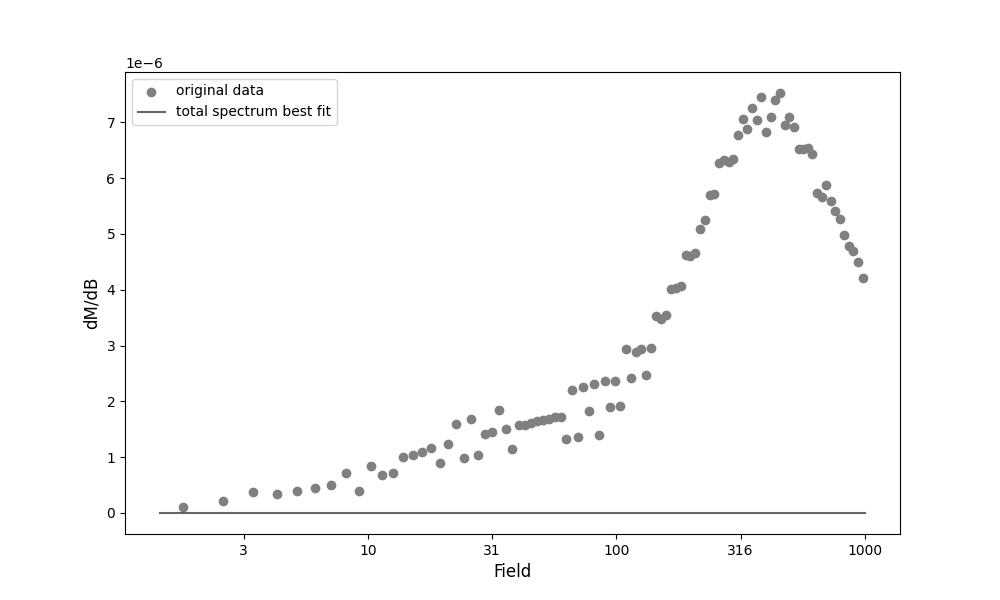

In [15]:
%matplotlib widget
interactive_backfield_fit(MaxUmnix_experiment['smoothed_log_dc_field'], 
                          MaxUmnix_experiment['smoothed_magn_mass_shift'], 
                          n_components=1, figsize=(10, 6))

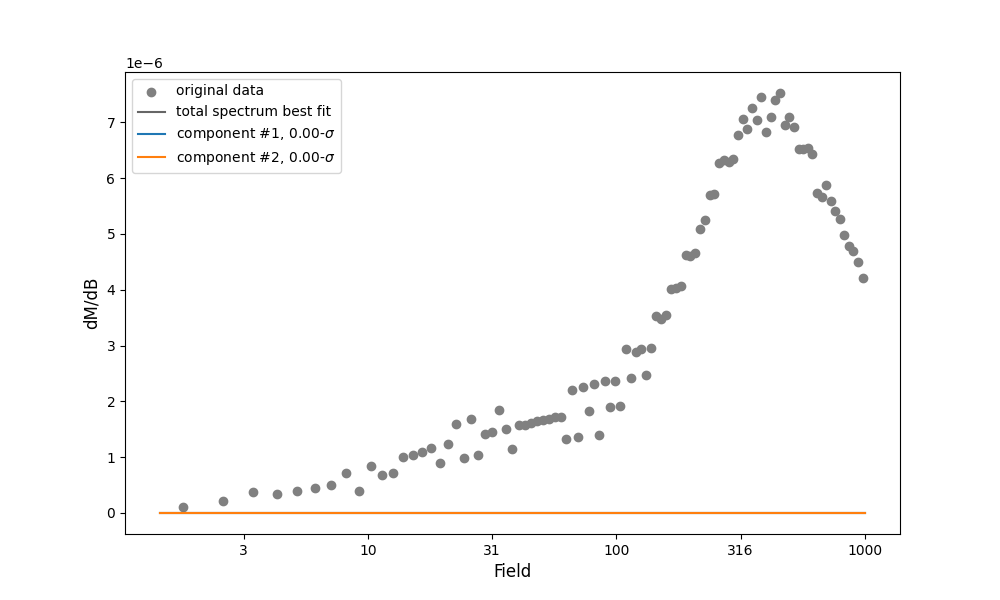

In [19]:
%matplotlib widget
interactive_backfield_fit(MaxUmnix_experiment['smoothed_log_dc_field'], 
                          MaxUmnix_experiment['smoothed_magn_mass_shift'], 
                          n_components=2, figsize=(10, 6))

In [34]:
# parameters = pd.DataFrame({'amplitude': [1], 'center': [950], 'sigma': [4.6], 'gamma': [-3]})
parameters = pd.DataFrame({'amplitude': [0.5, 0.5], 'center': [257, 17.5], 'sigma': [2.3, 646], 'gamma': [1.26, 4.6]})
parameters

,amplitude,center,sigma,gamma
0,0.5,257.0,2.3,1.26
1,0.5,17.5,646.0,4.60


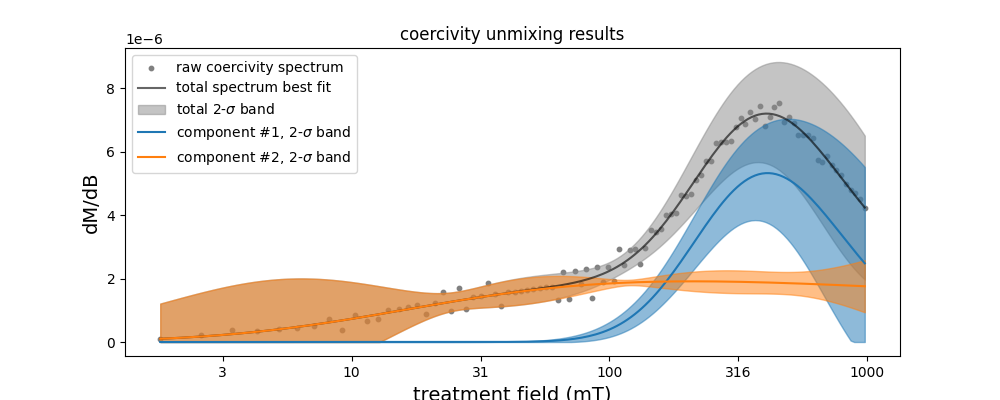

In [35]:
%matplotlib widget
result, updated_parameters = rmag.backfield_unmixing(MaxUmnix_experiment['smoothed_log_dc_field'], 
                                                    MaxUmnix_experiment['smoothed_magn_mass_shift'], 
                                                    n_comps=2, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(MaxUmnix_experiment, result, figsize=(10, 4))
# set legend on the left
ax.legend(loc='upper left', fontsize=10)
plt.show()

## Save the plot

Put the name of the file in the cell below. There are many available file formats for figures such as: `jpg`, `pdf`, `png`. Whatever you choose in the file name will be the file type.

Set the `save_directory`. If you want it to be the folder that the notebook is in, set it to be `'.'`.

In [ ]:
file_name = 'output.png'
save_directory = './example_data/SSRM2024C' 

file_path = save_directory + '/' + file_name
# fig.savefig(file_path, dpi=300)